# Down to Earth - An Example
This Jupyter notebook provides the code accompanying the example in Section 4.5. in [1].
The example is based on the model employed in [2].

This notebook was written by Anna Kutschireiter (anna.kutschireiter@gmail.com) and any feedback is highly appreciated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

## Nonlinear filtering for dynamic decision making


Let us consider the following example from dynamical decision making: 

In order to make a decision that relies on an unobserved, but dynamic, variable, animals have to be able to integrate the (noisy) observations about this variable in a way that discounts older evidence in favor of more recent evidence, depending on the dynamics of the variable. In other words: they have to do filtering. In [2] an experimental paradigm is considered where the hidden variable can be in one of two states, i.e. $X_t \in \{S1,S2\}$, which switches states with a hazard rate $a$ and which influences the click rates $r_{+}$ and $r_{−}$ of two speakers. More precisely, whenever the system is in state $S_1$, speaker 1 will have click rate $r_{+}$ and speaker 2 will have click rate $r_{−}$, and vice versa if the system is in state $S_2$. Presented with clicks from these speakers, rats have to make a decision about the state the environment is in at the end of the trial.

### Data generation

In [2]:
def HMM_hidden_step(x_0,alpha,beta):
    # One step in the hidden state transition of a 2D HMM, with states denoted by X=1 and X=2.
    # Here, alpha denotes the probability to stay in S1 and beta denotes the probability to stay in S2
    
    # define state transition matrix
    P = np.array([[alpha, 1-alpha], [1-beta, beta]])
    
    if x_0 == 1:
        x_1 = np.random.choice(np.array([1,2],dtype=int),replace=True,p=P[0])
    elif x_0 == 2:
        x_1 = np.random.choice(np.array([1,2],dtype=int),replace=True,p=P[1])
        
    return x_1

In [3]:
np.random.seed(48) # seed used for figure in [1]

# Simulation parameters
T = 2 # s
dt = 0.0001 # s
t = np.arange(0,T,dt)

# model parameters
a = 1 # Hz, hazard rate
r_plus = 38 # Hz
r_minus = 2 # Hz

# HMM parameters
alpha = 1 - a * dt # probability of staying in state 1 when being in state 1
beta = 1 - a * dt # probability of staying in state 2 when being in state 2
def h(X): 
    # observation function
    # returns vector of speaker click rates when being in state X
    if X == 1:
        h_out = np.array([r_plus,r_minus])
    elif X == 2:
        h_out = np.array([r_minus,r_plus])
    return h_out

X = np.ones(int(T/dt),dtype=int) # hidden state, starts at state 1
Y = np.zeros((int(T/dt),2),dtype=int) # point process observations
Y[0] = np.random.poisson(lam=h(X[0])*dt)
for i in range(1,int(T/dt)):
    # state transition and observation dynamics
    X[i] = HMM_hidden_step(X[i-1],alpha,beta)
    Y[i] = np.random.poisson(lam=h(X[i])*dt)

### Filtering

In [4]:
# adjoint of the generator of the hidden process
P_dot_trans = np.array([[-a, a], [a, -a]])

# initialize posterior density
p_hat = np.zeros([int(T/dt),2])
p_hat[0] = [0.999,0.001]

# initialize log posterior ratio
alph_hat = np.zeros(int(T/dt)) 
alph_hat[0] = np.log(0.999/0.001)

for i in range(1,int(T/dt)):
    
    # propagate according to state dynamics
    dp_0 = np.dot(P_dot_trans,p_hat[i-1]) * dt
    # include observations 
    h_hat = np.dot(np.array([h(1),h(2)]),p_hat[i-1])
    dp_1 = p_hat[i-1,0] * np.sum( (h(1) - h_hat) * 1/h_hat * ( Y[i] - h_hat * dt ) ) 
    dp_2 = p_hat[i-1,1] * np.sum( (h(2) - h_hat) * 1/h_hat * ( Y[i] - h_hat * dt ) ) 
    p_hat[i] = p_hat[i-1] + dp_0 + np.array([dp_1,dp_2])
    
    # for comparison:
    # propagate log posterior ratio directly (cf. [2], Eq 9)
    alph_hat[i] = alph_hat[i-1] + np.log(r_plus/r_minus) * (Y[i,0]-Y[i,1]) - 2 * a * np.sinh(alph_hat[i-1]) * dt


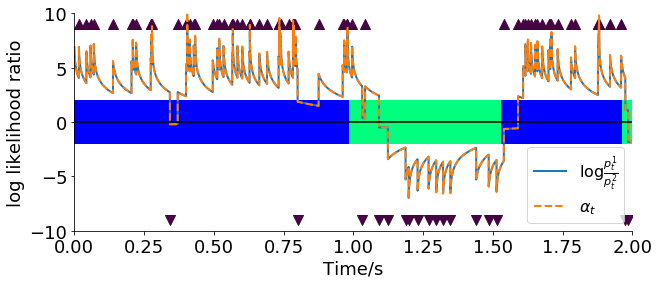

In [6]:
t_plus = t[Y[:,0]==1]
t_minus = t[Y[:,1]==1]
fig1, ax1 = plt.subplots(1,1,figsize=(10,4))
ax1.plot(t,np.log(p_hat[:,0]/p_hat[:,1]),linewidth=2)
ax1.plot(t,alph_hat,linewidth=2,linestyle='--')
ax1.legend([r'$\log \frac{p_t^1}{p_t^2}$',r'$\alpha_t$'],fontsize=16)
ax1.plot([0,T],[0,0],color='xkcd:black')
ax1.scatter(t_plus,9*np.ones(t_plus.size),marker="^",c='xkcd:eggplant purple',s=100)
ax1.scatter(t_minus,-9*np.ones(t_minus.size),marker="v",c='xkcd:eggplant purple',s=100)
ax1.set_ylim([-10,10])
ax1.set_xlim([0,T])
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False) 
ax1.set_xlabel('Time/s')
ax1.set_ylabel('log likelihood ratio')
ax1.imshow(np.array([X,X]),cmap='winter',aspect='auto',extent=[0,T,-2,2])
plt.savefig('41_example.pdf',bbox_inches='tight')
plt.show()

## References
[1] Kutschireiter, A., Surace, S. C., & Pfister, J.-P. (2019). The Hitchhikers Guide to Nonlinear Filtering. ArXiv, 1–42. Retrieved from http://arxiv.org/abs/1903.09247 

[2] Piet, A. T., Hady, A. El, Brody, C. D., El Hady, A., & Brody, C. D. (2018). Rats adopt the optimal timescale for evidence integration in a dynamic environment. Nature Communications, 9(1), 1–12. https://doi.org/10.1038/s41467-018-06561-y